In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import ascii, fits
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
#from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, Moffat2D_OIII
%config InlineBackend.figure_format = 'retina'

In [48]:
# functions

data = ascii.read("M87_data/wavelength.txt", names=["wavelength"])
wavelength = np.array(data["wavelength"])

# Open Fits file and assign to tdata
hdulist = fits.open("M87_data/M87_rescube.fits")
Flux_data = (hdulist[0].data)
# Reshape into a datacube 318x315x271
Flux_data_shape = np.array(Flux_data).reshape((318, 315, 271))

n_pixels=15

x_start = 51
y_start = 45
off = n_pixels/2
x_PNe = [
    # First Column
    x_start, x_start + 2* off, x_start + 4* off, x_start + 6*off, x_start + 8*off, x_start+10*off, 
    x_start+12*off, x_start+14*off, x_start+16*off, x_start+18*off,
    # Second Column
    x_start, x_start + 2* off, x_start + 4* off, x_start + 6*off, x_start + 8*off, x_start+10*off, 
    x_start+12*off, x_start+14*off, x_start+16*off, x_start+18*off,
    # Third Column
    x_start, x_start + 2* off, x_start + 4* off, x_start + 6*off, x_start + 8*off, x_start+10*off, 
    x_start+12*off, x_start+14*off, x_start+16*off, x_start+18*off,
    # Fourth Column
    58, 58+2*off, 58+4*off, 58+6*off, 58, 58+2*off, 58+2*off, 58+4*off, 58+6*off, 58+8*off,
    # Fifth Column
    15, 15+2*off, 15+4*off, 15+6*off, 15+8*off, 15+10*off, 15+12*off, 15+14*off, 15+16*off, 15+18*off,
    15, 15+2*off, 15+4*off, 15+6*off, 15+8*off, 15+10*off, 15+12*off, 15+14*off, 15+16*off, 15+18*off,
    
    ]
y_PNe = [
    # First Column rows
    y_start, y_start, y_start, y_start, y_start, y_start, y_start, y_start, y_start, y_start, 
    # Second Column rows
    y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, y_start-2*off, 
    # Third Column rows
    y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, y_start-4*off, 
    # Fourth Column rows
    103, 103, 103, 103, 103-2*off, 103-2*off, 103+2*off, 103+2*off, 103+2*off, 103+2*off,
    # Fifth Column rows
    302, 302, 302, 302, 302, 302, 302, 302, 302, 302,
    302-2*off,302-2*off, 302-2*off, 302-2*off, 302-2*off, 302-2*off, 302-2*off, 302-2*off, 302-2*off, 302-2*off, 
    # sixth column rows
    ]


X_AOI, Y_AOI = np.mgrid[:n_pixels,:n_pixels]

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source

flatten = lambda l: [item for sublist in l for item in sublist]
   
def extractor(x, y, n_pix, data, wave):
    x = round(x)
    y = round(y)
    if n_pix %2 == 1.0:
        offset = (0.5*n_pix)+0.5
    elif n_pix %2 == 0.0:
        offset = (0.5*n_pix)
    left_x = x - offset
    right_x = left_x + n_pix
    top_y = y - offset
    bottom_y = top_y + n_pix
    # select the spectra of interest
    extract_from_data = data[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    output = extract_from_data.reshape(n_pix**2, len(wave))
    
    return output



60


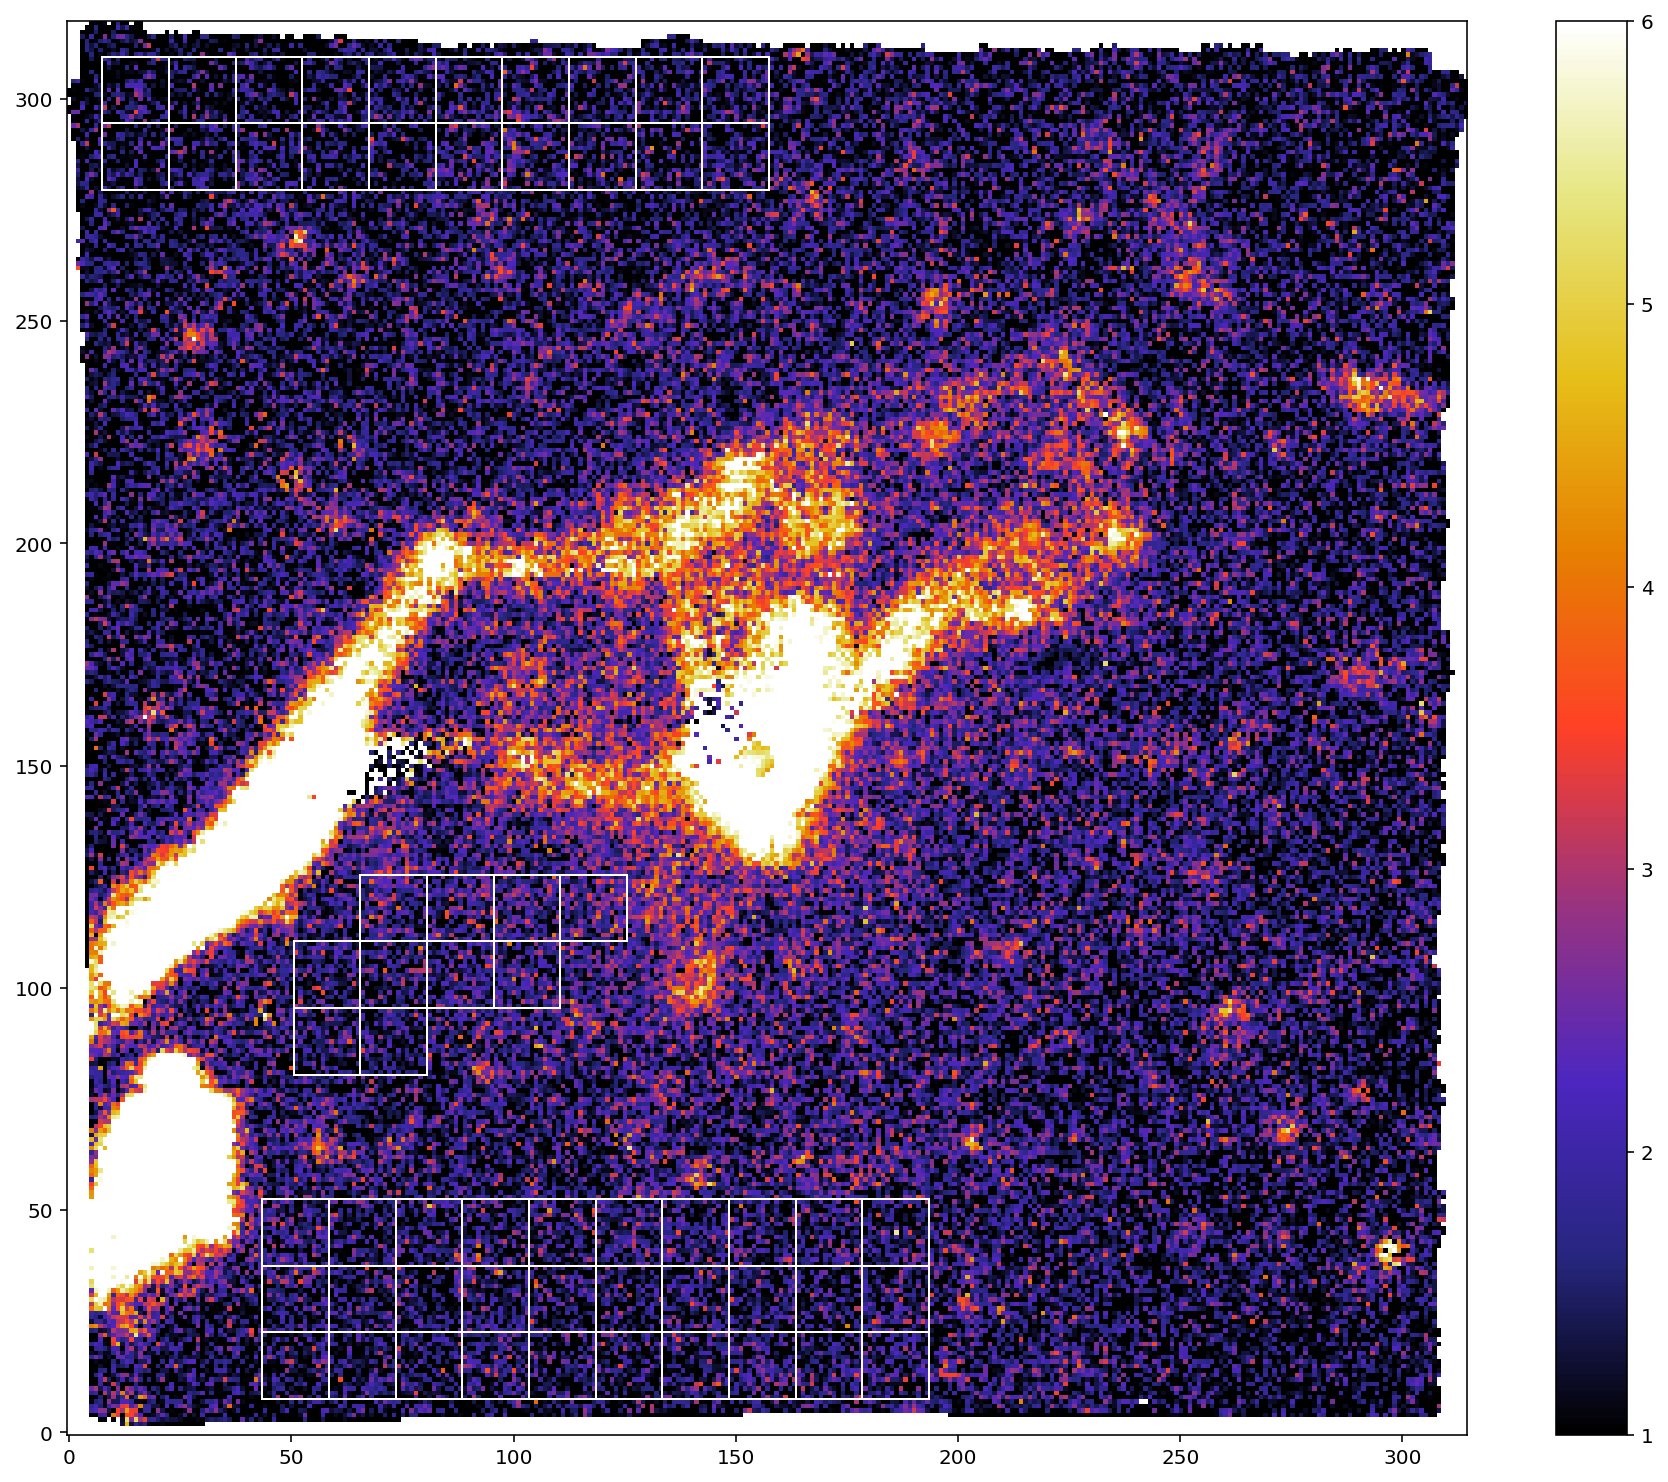

In [49]:
## Plot map
A_rN = np.load("exported_data/M87/A_rN.npy")
A_rN_shape = A_rN.reshape(318,315)

print(len(x_PNe))

plt.figure(2,figsize=(16,13))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=6)
cb = plt.colorbar()
for i, (x,y) in enumerate(zip(x_PNe, y_PNe)):
    ax = plt.gca()
    ax.add_patch(Rectangle((x-n_pixels/2, y-n_pixels/2), n_pixels, n_pixels, fill=False, edgecolor="white"))
    plt.draw()

In [53]:
## Pull out a cube of noise area from coordinates
noise_cube = np.array([extractor(x, y, n_pixels, Flux_data_shape, wavelength) for x,y in zip(x_PNe, y_PNe)])
print(noise_cube.shape)

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN","stddev", "gamma", "alpha"))
PNe_df["PNe number"] = np.arange(1,len(x_PNe)+1)
# .loc(Row, column name)

#construct error cube
error_cube = np.zeros((len(x_PNe), n_pixels**2, len(wavelength)))

for PNe_num in np.arange(0, len(x_PNe)):
    list_of_std = [np.abs(np.std(spec)) for spec in noise_cube[PNe_num]]
    error_cube[PNe_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

(60, 225, 271)


In [54]:
# Parameter setup

params = Parameters()
params.add('moffat_amp', value=200., min=0.0, max=1000.0)
params.add('x_0', value=(n_pixels/2), min=0., max=n_pixels)
params.add('y_0', value=(n_pixels/2), min=0., max=n_pixels)
params.add('gamma', value=2.8268, min=0., max=6., vary=False)
params.add("alpha", value=0.8615, min=0., max=6., vary=False) 
params.add("mean", value=5008., min=4990, max=5030)
params.add("Gauss_std", value=1.16, vary=False) # LSF, instrumental resolution.
params.add("Gauss_bkg",  value=1., min=-100., max=100.)
params.add("Gauss_grad", value=0.001, min=-2., max=2.)


# Gamma value=2.4325876573207847 +/- 0.0251 
# Alpha value=1.73296673762045 +/- 0.0175

In [55]:
def MUSE_3D_OIII(params, l, x_2D, y_2D, data):
    moffat_amp = params['moffat_amp']
    x_0 = params['x_0']
    y_0 = params['y_0']
    gamma = params['gamma']
    alpha = params["alpha"]
    mean = params["mean"]
    Gauss_std = params["Gauss_std"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]
    
    #Moffat model
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    F_OIII_xy = moffat_amp * (1 + rr_gg)**(-alpha)

    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - mean)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/3.0) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]

    
    plt.figure(1,figsize=(16,10))
    plt.clf()
    t= np.argmax(F_OIII_xy)
    plt.plot(l, data[t], c="blue")
    plt.plot(l, model_spectra[t], c="red")
    plt.xlabel("wavelength", fontsize=24)
    plt.ylabel("Flux", fontsize=24)
    
    return model_spectra, [np.sum(F_OIII_xy * 1e-20), np.std(data - model_spectra), np.max(A_OIII_xy), F_OIII_xy]

def MUSE_3D_residual(params, l, x_2D, y_2D, data, error, PNe_number, list_to_append_data):
    model = MUSE_3D_OIII(params, l, x_2D, y_2D, data)
    list_to_append_data.clear()
    list_to_append_data.append(model[1])

    return (data - model[0]) / error

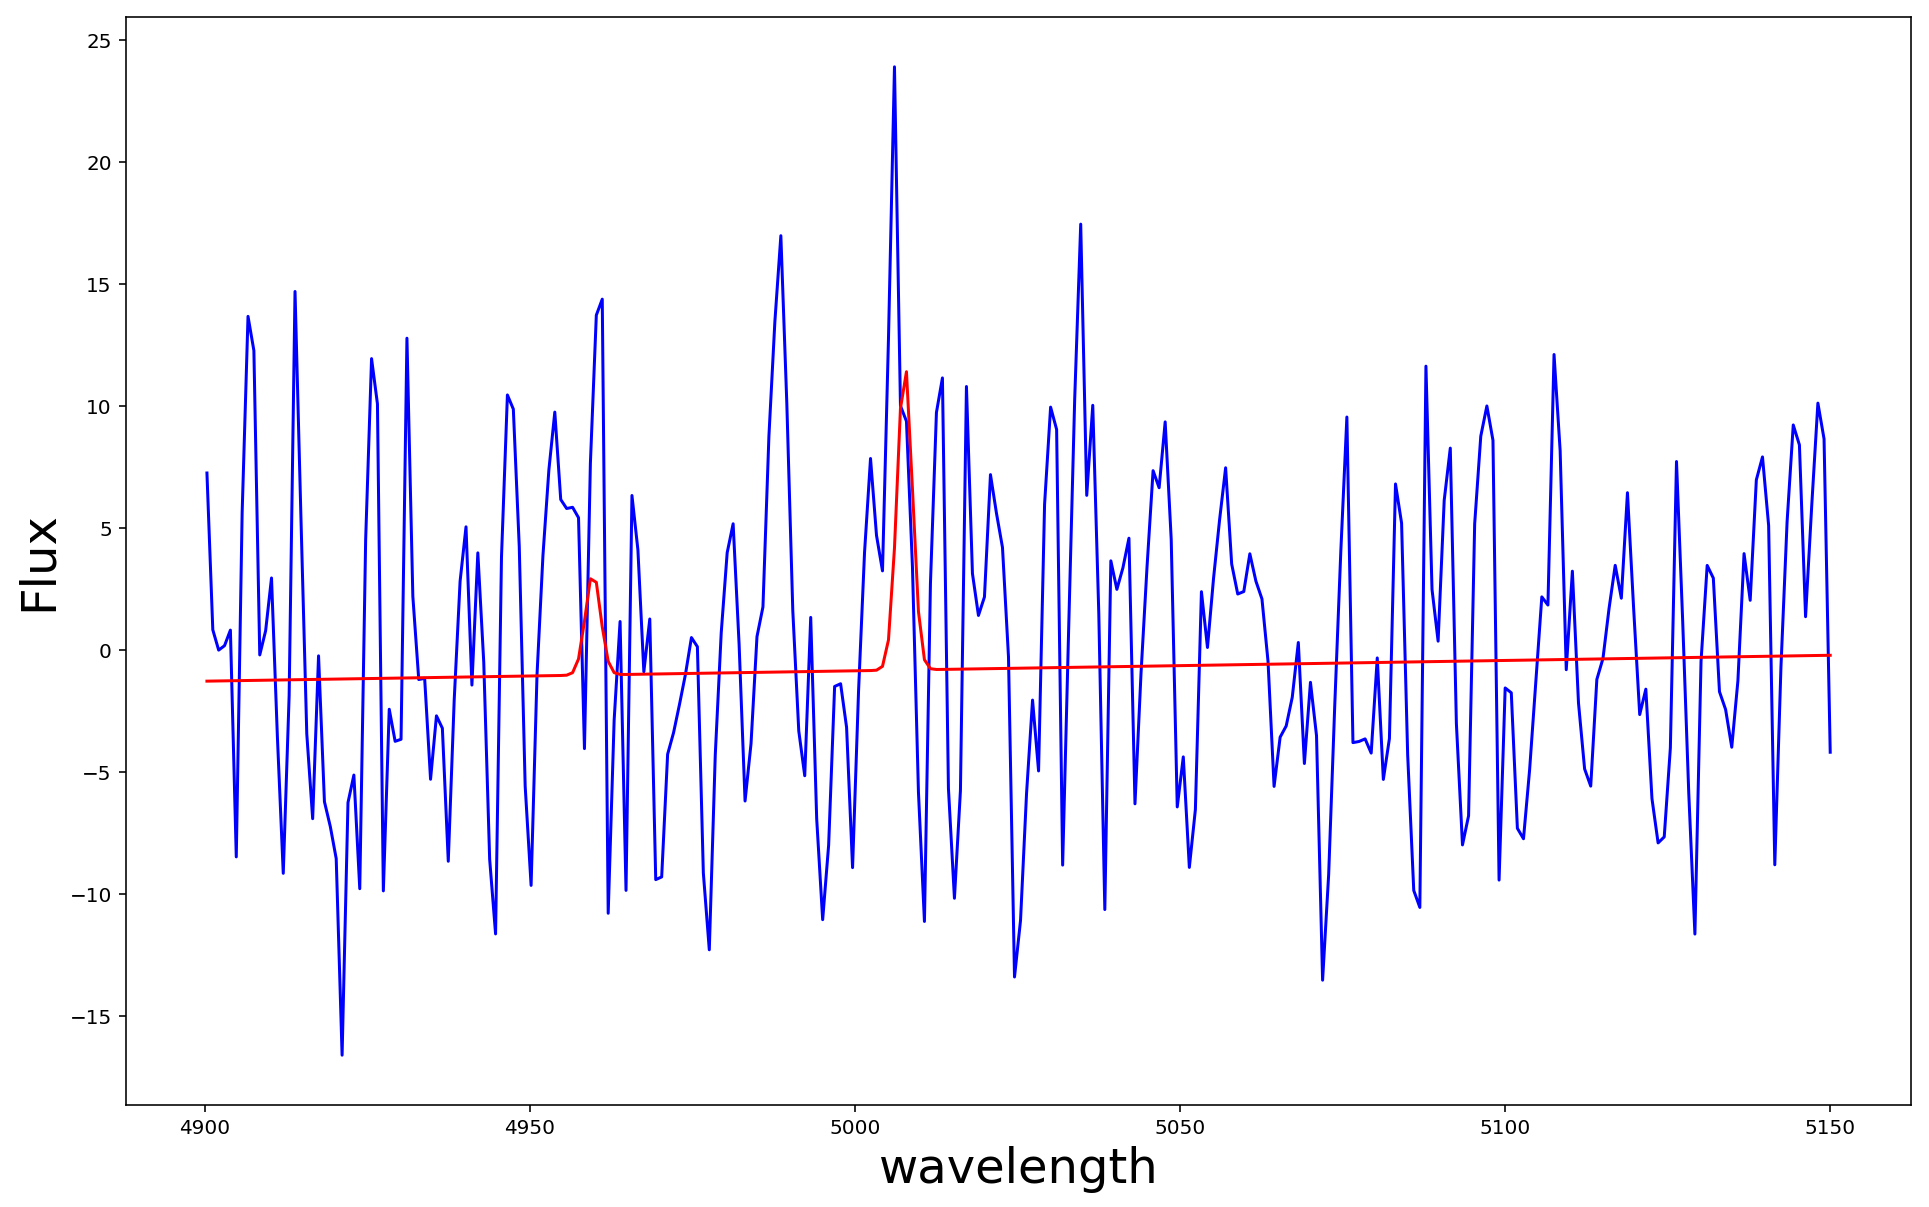

In [56]:
# useful value storage setup

total_Flux = np.zeros(len(x_PNe))
list_of_residuals = np.zeros(len(x_PNe))
list_of_A_OIII = np.zeros(len(x_PNe))
list_of_F_OIII_xy = np.zeros((len(x_PNe), len(noise_cube[0])))
list_of_M_amp = np.zeros(len(x_PNe))
list_of_means = np.zeros(len(x_PNe))
list_of_g_bkg = np.zeros(len(x_PNe))
list_of_g_grad = np.zeros(len(x_PNe))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_err = np.zeros(len(x_PNe))
g_bkg_err = np.zeros(len(x_PNe))
g_grad_err = np.zeros(len(x_PNe))

list_of_best_stddev = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
c = 299792458

#h = FloatProgress(min=0, max=len(x_PNe), description="Fitting:", bar_style='info')
#display(h)

for PNe_num in np.arange(0, len(x_PNe)):
    useful_stuff = []
    results = minimize(MUSE_3D_residual, params, args=(wavelength, x_fit, y_fit, noise_cube[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff), nan_policy="propagate")
    PNe_df.loc[PNe_num, "gamma"] = results.params["gamma"].value
    PNe_df.loc[PNe_num, "alpha"] = results.params["alpha"].value
    PNe_df.loc[PNe_num, "stddev"] = results.params["Gauss_std"].value
    PNe_df.loc[PNe_num, "Total Flux"] = useful_stuff[0][0]
    PNe_df.loc[PNe_num, "V (km/s)"] = (c * (results.params["mean"] - 5006.8) / 5006.8) / 1000
    list_of_best_stddev[PNe_num] = results.params["Gauss_std"]
    list_of_residuals[PNe_num] = useful_stuff[0][1]
    list_of_A_OIII[PNe_num] = useful_stuff[0][2]
    list_of_F_OIII_xy[PNe_num] = useful_stuff[0][3]
    list_of_M_amp[PNe_num] = results.params["moffat_amp"]
    list_of_x[PNe_num] = results.params["x_0"]
    list_of_y[PNe_num] = results.params["y_0"]
    list_of_means[PNe_num] = results.params["mean"]
    list_of_g_bkg[PNe_num] = results.params["Gauss_bkg"]
    list_of_g_grad[PNe_num] = results.params["Gauss_grad"]
    #save errors
    moff_A_err[PNe_num] = results.params["moffat_amp"].stderr
    x_0_err[PNe_num] = results.params["x_0"].stderr
    y_0_err[PNe_num] = results.params["y_0"].stderr
    mean_err[PNe_num] = results.params["mean"].stderr
    g_bkg_err[PNe_num] = results.params["Gauss_bkg"].stderr
    g_grad_err[PNe_num] = results.params["Gauss_grad"].stderr
    #h.value += 1

A_by_rN = list_of_A_OIII / list_of_residuals
PNe_df["A/rN"] = A_by_rN

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM = 31.28 #5. * np.log10(16.4) + 25
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

In [128]:
PNe_df

,PNe number,Total Flux,Flux error,V (km/s),m 5007,M 5007,M 5007 error,A/rN,stddev,gamma,alpha
0,1,1.7094e-22,NaN,76.2431,40.677892,9.397892,NaN,0.000040,1.19,2.14432,1.533
1,2,3.39924e-18,NaN,-79.2416,29.931547,-1.348453,NaN,1.080188,1.19,2.14432,1.533
2,3,3.16051e-18,NaN,120.557,30.010605,-1.269395,NaN,0.945092,1.19,2.14432,1.533
3,4,1.48965e-18,NaN,141.01,30.827290,-0.452710,NaN,0.404828,1.19,2.14432,1.533
4,5,5.06141e-18,NaN,-101.752,29.499321,-1.780679,NaN,1.379993,1.19,2.14432,1.533
5,6,4.57381e-18,NaN,85.5567,29.609306,-1.670694,NaN,1.040955,1.19,2.14432,1.533
6,7,2.67554e-18,NaN,128.382,30.191473,-1.088527,NaN,0.518169,1.19,2.14432,1.533
7,8,4.84034e-18,NaN,34.5379,29.547810,-1.732190,NaN,1.224301,1.19,2.14432,1.533
8,9,4.64145e-18,NaN,-51.4197,29.593365,-1.686635,NaN,1.426210,1.19,2.14432,1.533
9,10,3.58757e-18,NaN,131.148,29.873000,-1.407000,NaN,0.866795,1.19,2.14432,1.533


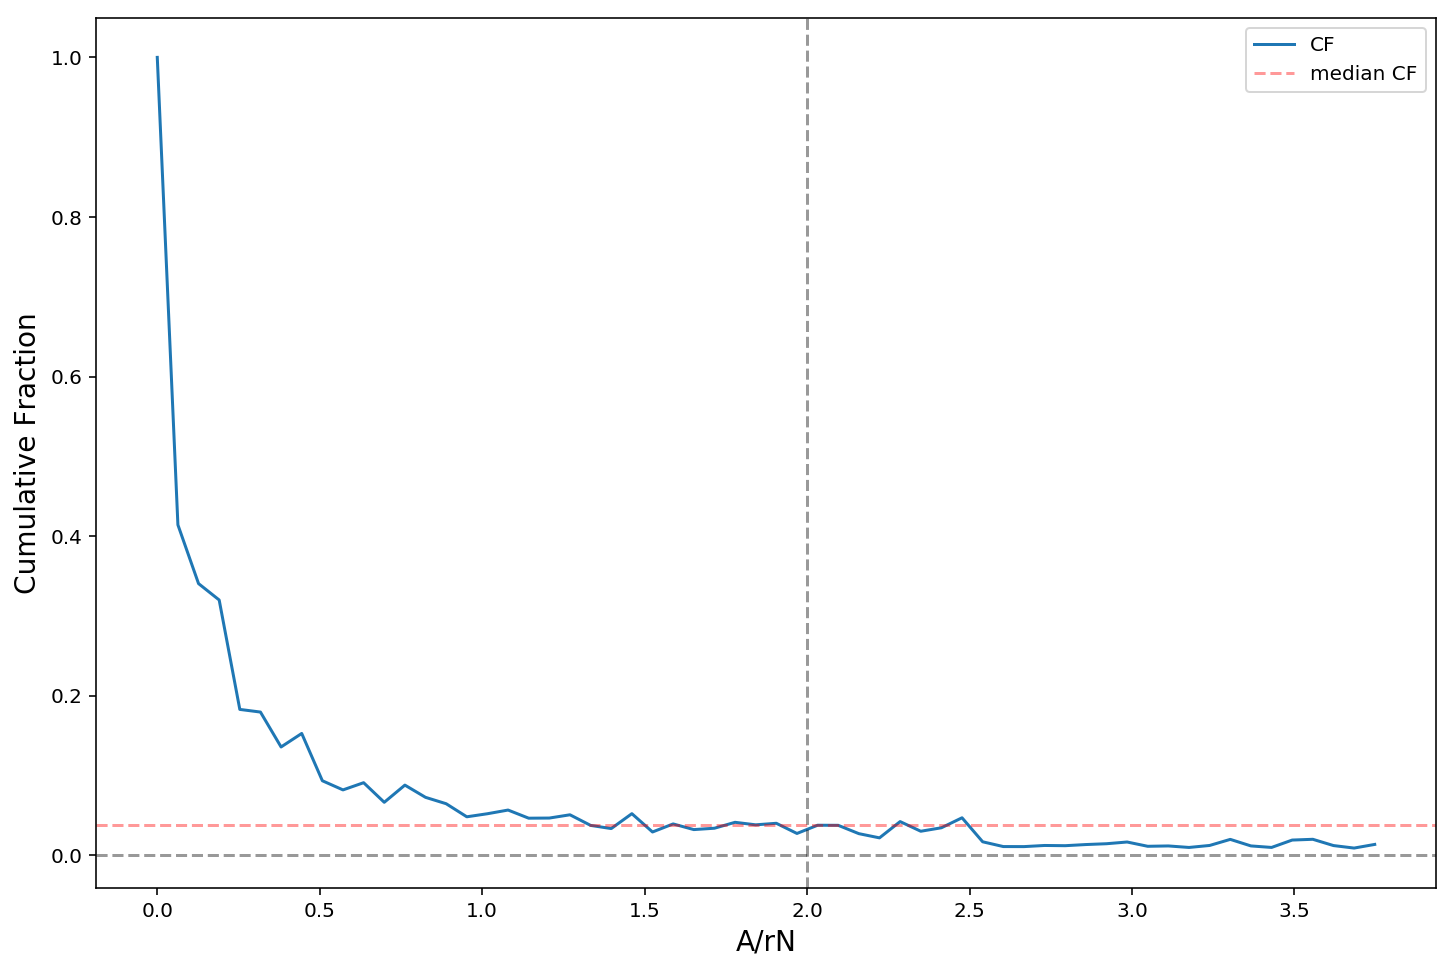

In [57]:
test_cum_sum = np.cumsum(PNe_df["A/rN"])
plt.figure(figsize=(12,8))
plt.plot(np.linspace(0,np.max(PNe_df["A/rN"]), len(test_cum_sum)), PNe_df["A/rN"]/test_cum_sum, label="CF")
plt.xlabel("A/rN", fontsize=14)
plt.ylabel("Cumulative Fraction", fontsize=14)
plt.axhline(y=0, c="k", ls="dashed", alpha=0.4)
plt.axvline(x=2, c="k", ls="dashed", alpha=0.4)
plt.axhline(y=np.median(PNe_df["A/rN"]/test_cum_sum), c="r", ls="dashed", alpha=0.4, label="median CF")
plt.legend()
plt.savefig("Plots/M87/CF.png")

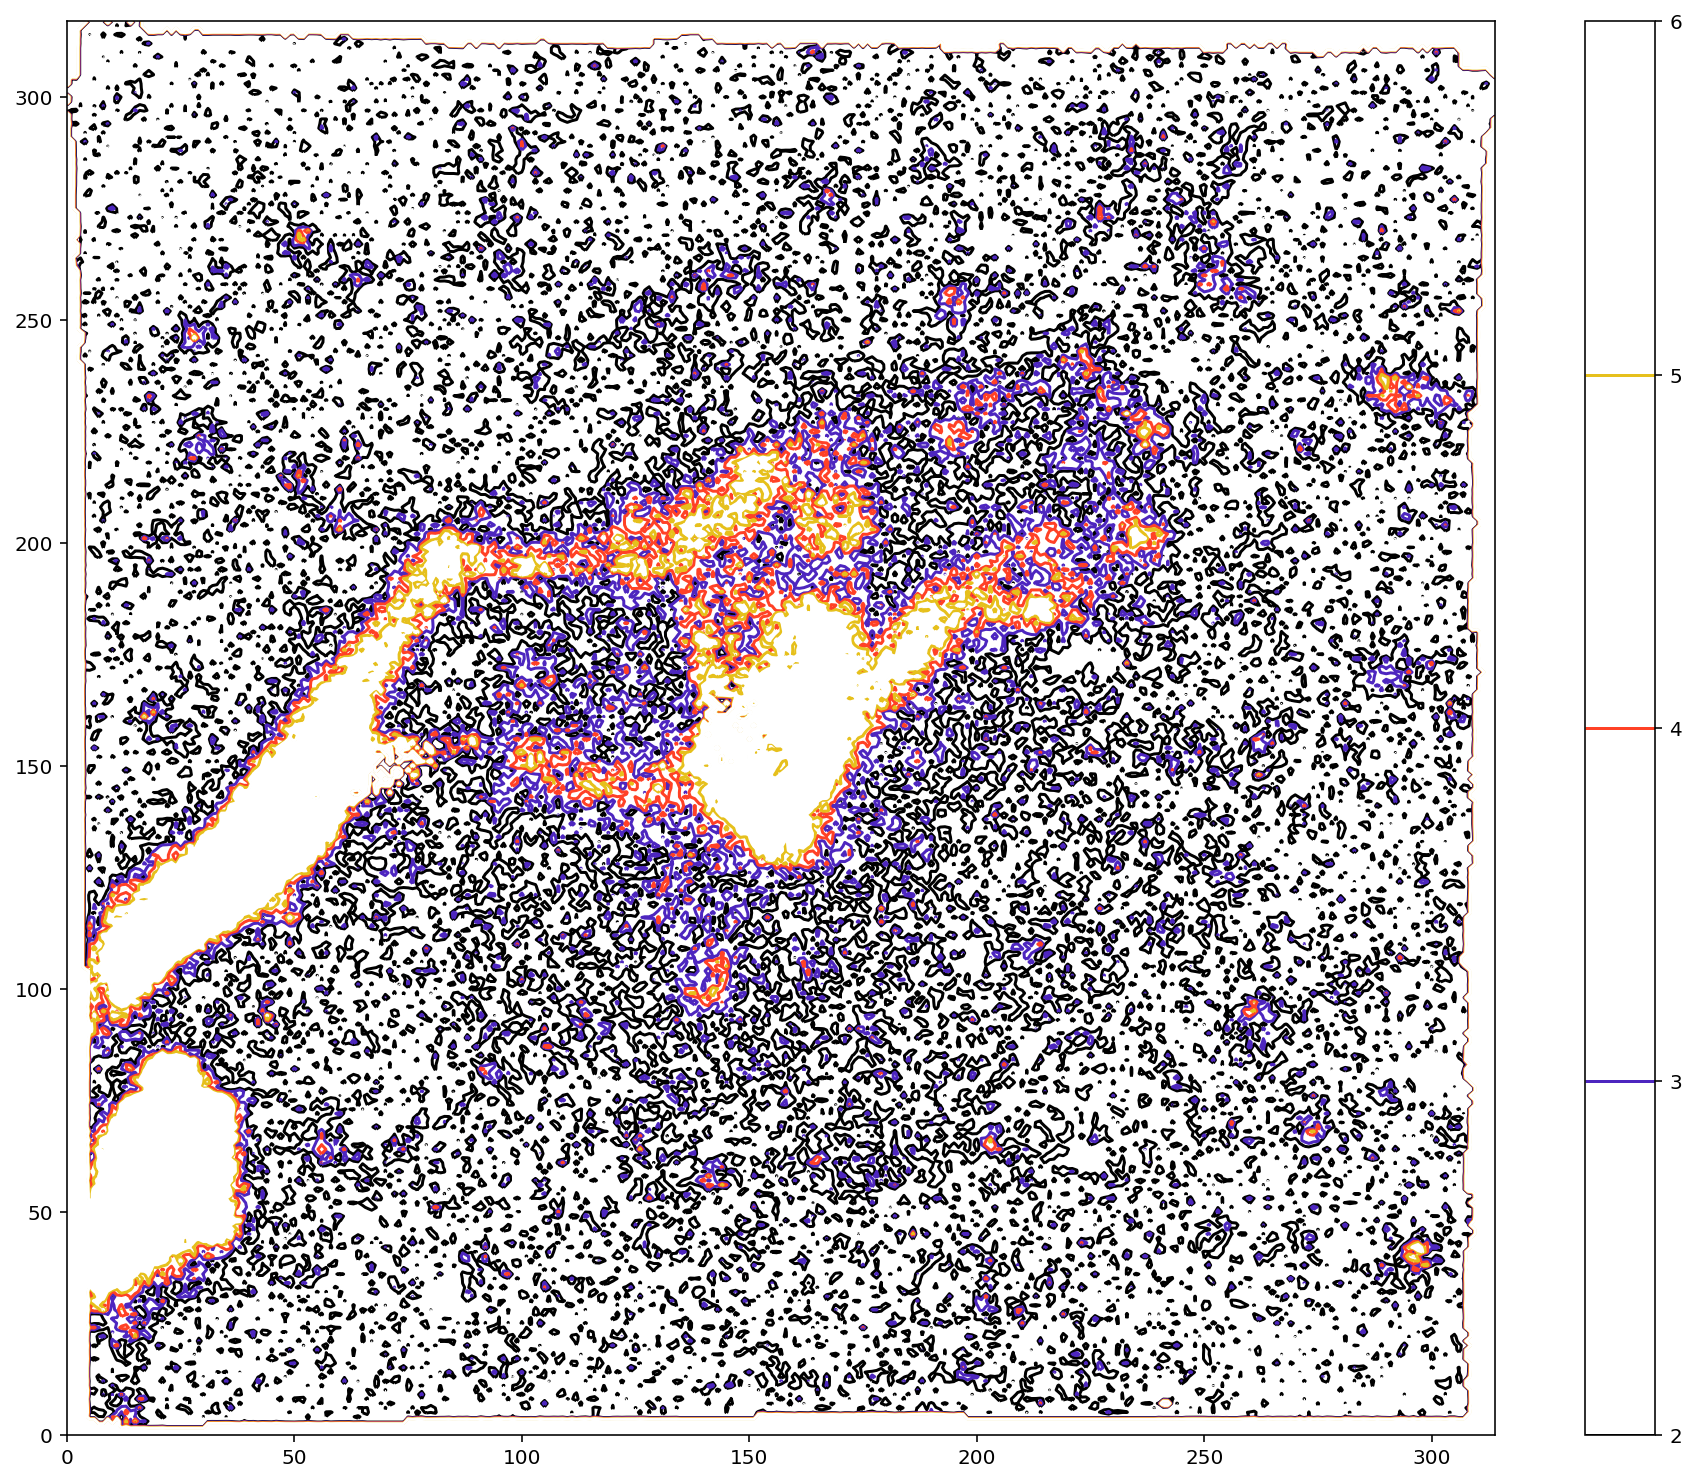

In [59]:
plt.figure(3, figsize=(16,13))
contour_x = np.arange(315)
contour_y = np.arange(318)
levels = [2.,3.,4., 5., 6.,]
cnt = plt.contour(contour_x,contour_y, A_rN_shape, levels=levels, cmap="CMRmap")
cb = plt.colorbar()